In [1]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install albumentations --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!python -m pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install torchvision --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install -U git+https://github.com/albumentations-team/albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-e7fn_32v
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-e7fn_32v
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125696 sha256=917f8a7edb3b88d2588c5fc67d2206addcbe4aa996edbd143a4dc27384ba6fae
  Stored in directory: /tmp/pip-ephem-wheel-cache-c8ykbioj/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [196]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [7]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
## 함수
datagen=ImageDataGenerator(
    zoom_range = 0.3,     
    width_shift_range=0.2, 
    height_shift_range=0.2
)

def auG(f_path, image_list, i, sub):
    for f in image_list:
            img_path = os.path.join(f_path, i, f)
            image = np.expand_dims(plt.imread(img_path), 0)
            c=0     
            for _ in datagen.flow(image,
                                    batch_size=1,
                                    save_to_dir=os.path.join(f_path,i),
                                    save_prefix=i,
                                    save_format='png'):
                c+=1
                if c > augment_number-(sub):
                    break

## 전역
f_path = '/content/gdrive/My Drive/open/Codes/basic/train'
f_list = os.listdir(f_path)
#f_list.remove('.DS_Store')


## 메인
for i in f_list:
    image_list=os.listdir(os.path.join(f_path,i)) 
    augment_number=10
    
    if len(image_list) > 600:
        continue
    elif 500 < len(image_list) < 600:
        auG(f_path,image_list, i, 7)
    elif 300 < len(image_list) < 400:
        auG(f_path,image_list, i, 5)
    elif 200 < len(image_list) < 300:
        auG(f_path,image_list, i, 2)
    elif 98 < len(image_list) < 200:
        auG(f_path,image_list, i, 0)
    elif 50 < len(image_list) < 60:
        auG(f_path,image_list, i, -20)
    elif 20 < len(image_list) < 30:
        auG(f_path,image_list, i, -70)
    elif 10< len(image_list) < 20:
        auG(f_path,image_list, i, -90)
    elif len(image_list) < 10:
        auG(f_path,image_list, i, -440)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [12]:
device

device(type='cuda')

In [533]:
## Hyperparameter Setting

CFG = {
    'IMG_SIZE':224,
    'EPOCHS': 5,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':128,
    'SEED': 41
}

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')
# 기본 경로

Mounted at /content/gdrive


In [15]:
# get dataset

all_img_list = glob.glob('/content/gdrive/My Drive/open/Codes/basic/train/*/*')
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[8])

In [16]:
df

,img_path,label
0,/content/gdrive/My Drive/open/Codes/basic/trai...,가구수정
1,/content/gdrive/My Drive/open/Codes/basic/trai...,가구수정
2,/content/gdrive/My Drive/open/Codes/basic/trai...,가구수정
3,/content/gdrive/My Drive/open/Codes/basic/trai...,가구수정
4,/content/gdrive/My Drive/open/Codes/basic/trai...,가구수정
...,...,...
31452,/content/gdrive/My Drive/open/Codes/basic/trai...,울음
31453,/content/gdrive/My Drive/open/Codes/basic/trai...,울음
31454,/content/gdrive/My Drive/open/Codes/basic/trai...,울음
31455,/content/gdrive/My Drive/open/Codes/basic/trai...,울음


In [17]:
df['img_path'][100]

'/content/gdrive/My Drive/open/Codes/basic/train/가구수정/가구수정_0_1949.png'

In [18]:
for filepath in all_img_list:
    print(filepath)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_1169.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_4941.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_5066.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_8266.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_5820.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_8803.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_2246.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_9512.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_3214.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_9847.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_5169.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_8228.png
/content/gdrive/My Drive/open/Codes/basic/train/터짐/터짐_0_8273.png
/content/gdrive/My Drive/open/Codes/basic

In [35]:
# split train val dataset
train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, stratify=df['label'], random_state=CFG['SEED'])

In [36]:
## Label-Encoding
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])

In [37]:
## CustomDataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [39]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.HorizontalFlip(p=0.5),
                            A.RandomBrightnessContrast(p=0.5),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [40]:
#weighted sampling
a_list = train['label'].value_counts()
class_counts = train['label'].value_counts().to_list()
class_weights = [1 / a_list[i] for i in range(len(class_counts))]
num_samples = sum(class_counts)
labels_lists = train['label'].to_list()
weights = [class_weights[labels_lists[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples), replacement=True)

In [41]:
# make dataloader
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], sampler=sampler, shuffle=False, num_workers=2)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

In [42]:
## Model Define

class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True) #densenet161(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha]*19)
        self.alpha[18] = 1-alpha
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [44]:
## Train

def trains(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
#     criterion = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
    criterion = FocalLoss(gamma=2, alpha=0.25)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    return best_model

In [45]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score

In [46]:
#init model
model = BaseModel()

In [534]:
model.load_state_dict(torch.load('model.pickle'))

<All keys matched successfully>

In [535]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])

In [536]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

In [ ]:
infer_model = trains(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/197 [00:00<?, ?it/s]

In [538]:
preds = []
true = []
inference_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=2)
with torch.no_grad() :
    for img, label in inference_loader :
        img = img.float().to(device)
        label = label.to(device)
        pred = infer_model(img)
        
        preds.extend(pred.argmax(1).detach().cpu().numpy())
        true.extend(label.detach().cpu().numpy().tolist())

In [539]:
preds_save = preds
preds_save

[16,
 7,
 6,
 1,
 4,
 12,
 15,
 5,
 7,
 6,
 11,
 16,
 1,
 4,
 16,
 5,
 11,
 0,
 13,
 10,
 6,
 15,
 14,
 6,
 0,
 2,
 10,
 17,
 15,
 5,
 18,
 4,
 2,
 12,
 18,
 15,
 1,
 0,
 1,
 8,
 3,
 1,
 15,
 3,
 3,
 13,
 1,
 9,
 13,
 18,
 17,
 3,
 5,
 16,
 3,
 10,
 10,
 16,
 9,
 4,
 8,
 7,
 12,
 5,
 15,
 13,
 8,
 7,
 10,
 12,
 1,
 8,
 8,
 9,
 4,
 18,
 9,
 4,
 7,
 10,
 5,
 3,
 4,
 18,
 2,
 10,
 1,
 10,
 7,
 6,
 12,
 9,
 10,
 0,
 13,
 10,
 8,
 3,
 4,
 9,
 15,
 12,
 12,
 1,
 10,
 5,
 3,
 12,
 10,
 11,
 18,
 5,
 17,
 8,
 7,
 3,
 3,
 5,
 6,
 7,
 10,
 5,
 15,
 3,
 17,
 10,
 5,
 6,
 15,
 11,
 16,
 10,
 3,
 10,
 12,
 0,
 16,
 12,
 8,
 16,
 14,
 9,
 5,
 2,
 17,
 7,
 5,
 18,
 14,
 6,
 1,
 14,
 14,
 1,
 15,
 12,
 16,
 5,
 4,
 14,
 3,
 11,
 6,
 12,
 6,
 18,
 13,
 1,
 15,
 18,
 2,
 16,
 13,
 13,
 14,
 3,
 9,
 10,
 17,
 5,
 15,
 5,
 3,
 6,
 4,
 6,
 18,
 2,
 7,
 15,
 16,
 12,
 5,
 12,
 11,
 18,
 1,
 10,
 1,
 14,
 9,
 10,
 11,
 10,
 13,
 8,
 9,
 16,
 7,
 13,
 14,
 9,
 1,
 15,
 1,
 15,
 16,
 1,
 13,
 10,
 4,
 2,
 16,


In [540]:
from sklearn.metrics import confusion_matrix

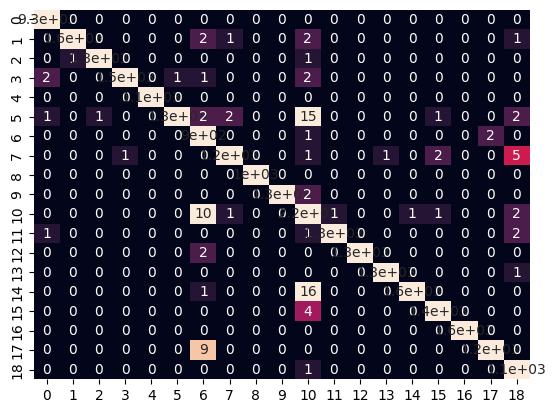

In [541]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(confusion_matrix(true, preds), annot=True, vmax = 10, vmin=0, cbar=False)
plt.show()

In [542]:
train['pred'] = preds
train['true'] = true

In [543]:
train.head()

,img_path,label,pred,true,err
29108,/content/gdrive/My Drive/open/Codes/basic/trai...,16,16,16,True
7027,/content/gdrive/My Drive/open/Codes/basic/trai...,7,7,7,True
11596,/content/gdrive/My Drive/open/Codes/basic/trai...,6,6,6,True
3077,/content/gdrive/My Drive/open/Codes/basic/trai...,1,1,1,True
13371,/content/gdrive/My Drive/open/Codes/basic/trai...,4,4,4,True


In [544]:
train['err'] = train['pred'] == train['label']

In [545]:
err_ds = train.loc[(train['err'] == False)].copy()

In [546]:
img_err = err_ds['img_path'].values

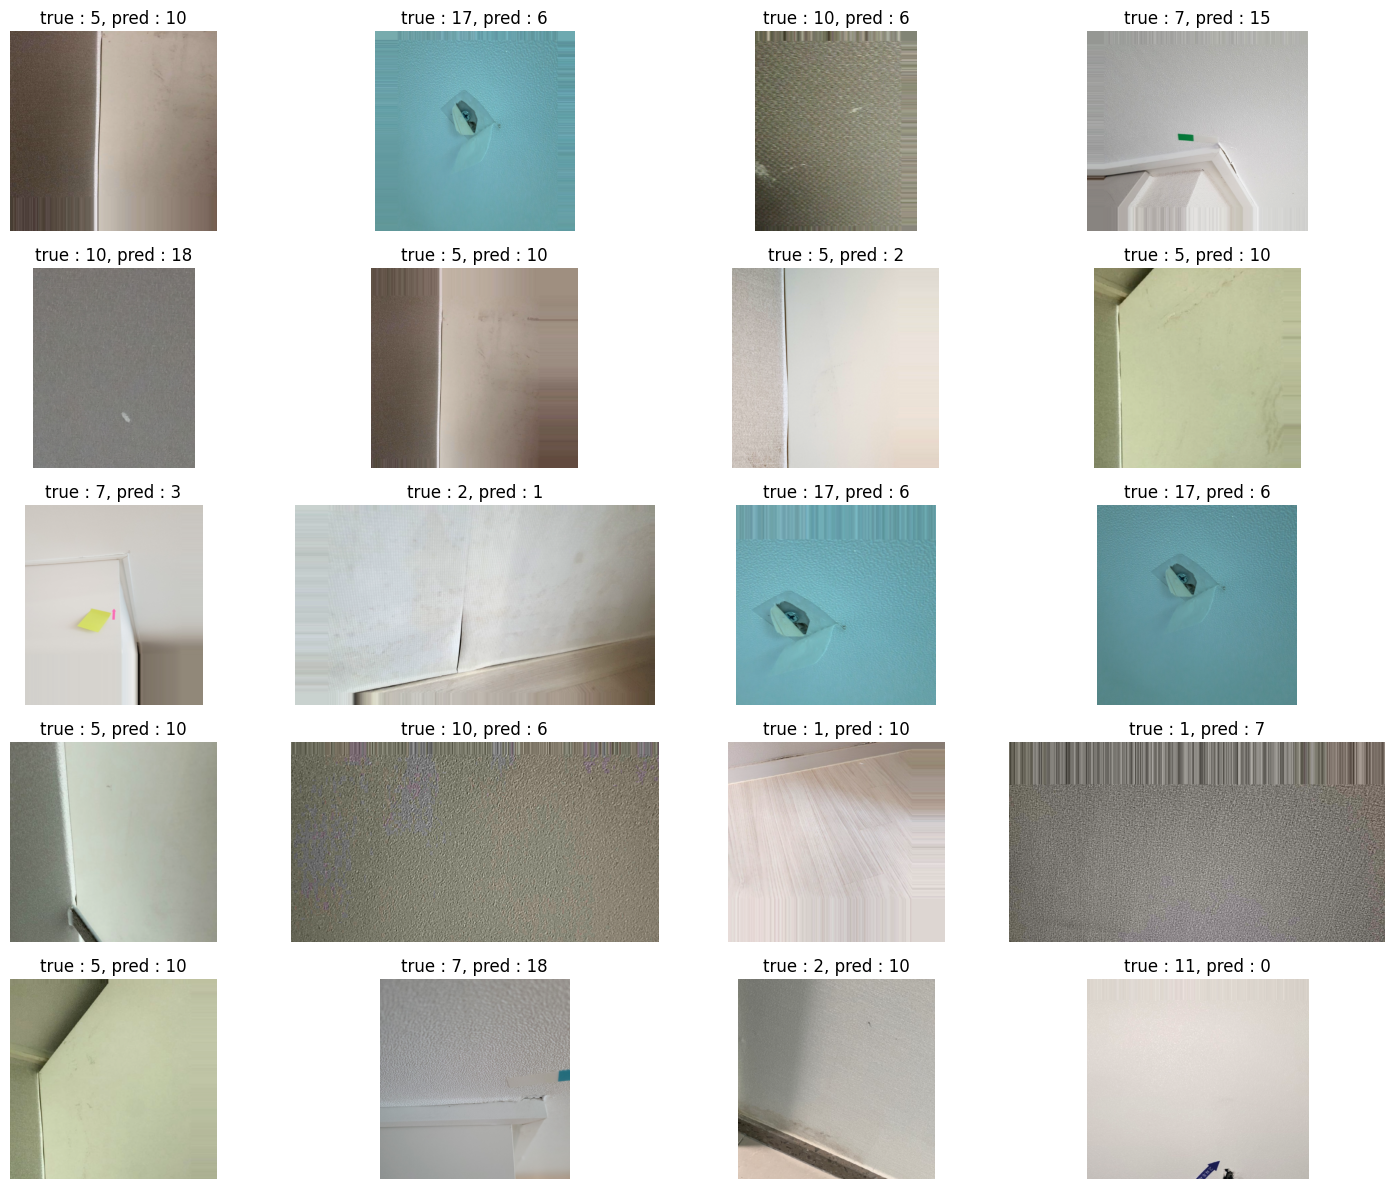

In [547]:
plt.figure(figsize=(15,12))
for i in range(20):
    plt.subplot(5,4,i+1)
    im = Image.open(err_ds['img_path'].values[i])
    plt.imshow(im)
    plt.axis('off')
    tr = err_ds['label'].values[i]
    pr = err_ds['pred'].values[i]
    plt.title(f'true : {tr}, pred : {pr}')
plt.tight_layout()
plt.show()

In [548]:
#test
test = pd.read_csv('/content/gdrive/My Drive/open/Codes/basic/test.csv')

In [511]:
test

,id,img_path
0,TEST_000,./test/000.png
1,TEST_001,./test/001.png
2,TEST_002,./test/002.png
3,TEST_003,./test/003.png
4,TEST_004,./test/004.png
...,...,...
787,TEST_787,./test/787.png
788,TEST_788,./test/788.png
789,TEST_789,./test/789.png
790,TEST_790,./test/790.png


In [549]:
test["img_path_real"] = test["img_path"].str.replace(".","/content/gdrive/My Drive/open/Codes/basic", 1)

In [513]:
test

,id,img_path,img_path_real
0,TEST_000,./test/000.png,/content/gdrive/My Drive/open/Codes/basic/test...
1,TEST_001,./test/001.png,/content/gdrive/My Drive/open/Codes/basic/test...
2,TEST_002,./test/002.png,/content/gdrive/My Drive/open/Codes/basic/test...
3,TEST_003,./test/003.png,/content/gdrive/My Drive/open/Codes/basic/test...
4,TEST_004,./test/004.png,/content/gdrive/My Drive/open/Codes/basic/test...
...,...,...,...
787,TEST_787,./test/787.png,/content/gdrive/My Drive/open/Codes/basic/test...
788,TEST_788,./test/788.png,/content/gdrive/My Drive/open/Codes/basic/test...
789,TEST_789,./test/789.png,/content/gdrive/My Drive/open/Codes/basic/test...
790,TEST_790,./test/790.png,/content/gdrive/My Drive/open/Codes/basic/test...


In [550]:
test["img_path_real"][1]

'/content/gdrive/My Drive/open/Codes/basic/test/001.png'

In [551]:
test_dataset = CustomDataset(test['img_path_real'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

In [552]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(test_loader):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

In [553]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/7 [00:00<?, ?it/s]

In [554]:
#submission
submit = pd.read_csv('/content/gdrive/My Drive/open/Codes/basic/sample_submission.csv')

In [519]:
submit

,id,label
0,TEST_000,훼손
1,TEST_001,훼손
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,훼손
...,...,...
787,TEST_787,훼손
788,TEST_788,훼손
789,TEST_789,훼손
790,TEST_790,훼손


In [555]:
submit['label'] = preds

In [359]:
preds

array(['훼손', '오염', '훼손', '몰딩수정', '훼손', '훼손',
       '오염', '훼손', '오염', '오타공', '몰딩수정', '오타공',
       '오염', '오염', '훼손', '오염', '훼손', '터짐', '오염',
       '오염', '창틀,문틀수정', '훼손', '훼손', '터짐', '훼손',
       '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손',
       '훼손', '오염', '훼손', '훼손', '훼손', '훼손', '오타공',
       '훼손', '오염', '훼손', '오염', '면불량', '훼손',
       '석고수정', '오염', '울음', '오염', '훼손', '오염',
       '오염', '훼손', '훼손', '훼손', '훼손', '반점', '훼손',
       '훼손', '오염', '오타공', '몰딩수정', '훼손', '오염',
       '훼손', '훼손', '오염', '훼손', '훼손', '터짐', '오염',
       '오염', '오염', '오염', '훼손', '석고수정', '훼손', '훼손',
       '터짐', '오염', '훼손', '훼손', '훼손', '훼손',
       '걸레받이수정', '훼손', '훼손', '터짐', '오염', '오염',
       '오염', '훼손', 'ᄒ

In [393]:
submit.head()

,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,오염


In [176]:
#folder_list = os.listdir('/content/gdrive/My Drive/open/Codes/basic/train')
#folder_list.sort()
#folder_list

['가구수정',
 '걸레받이수정',
 '곰팡이',
 '꼬임',
 '녹오염',
 '들뜸',
 '면불량',
 '몰딩수정',
 '반점',
 '석고수정',
 '오염',
 '오타공',
 '울음',
 '이음부불량',
 '창틀,문틀수정',
 '터짐',
 '틈새과다',
 '피스',
 '훼손']

In [556]:
import unicodedata
label_data = [unicodedata.normalize('NFC', one_ans_val) for one_ans_val in preds]

In [268]:
preds

array(['훼손', '오염', '훼손', '훼손', '훼손', '훼손', '오염',
       '오염', '오염', '오염', '훼손', '오타공', '오염', '오염',
       '훼손', '오염', '훼손', '면불량', '오염', '오염',
       '곰팡이', '훼손', '오염', '터짐', '가구수정', '훼손',
       '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손',
       '오염', '곰팡이', '훼손', '훼손', '훼손', '오타공', '훼손',
       '오염', '훼손', '곰팡이', '꼬임', '훼손', '훼손', '오염',
       '훼손', '오염', '오염', '오염', '오염', '오염', '훼손',
       '훼손', '훼손', '훼손', '훼손', '훼손', '오염', '오타공',
       '훼손', '훼손', '오염', '훼손', '훼손', '오염', '훼손',
       '훼손', '석고수정', '오염', '오염', '오염', '오염', '훼손',
       '터짐', '훼손', '훼손', '훼손', '오염', '오염', '훼손',
       '오염', '훼손', '걸레받이수정', '훼손', '오염', '훼손',
       '오염', '오염', '오염', '훼손', '훼손', '터짐', '훼손',
       'ᄒ

In [201]:
submit['label'] = submit['label'].map(dict(zip(range(19),label_data)))
submit

,id,label
0,TEST_000,NaN
1,TEST_001,NaN
2,TEST_002,NaN
3,TEST_003,NaN
4,TEST_004,NaN
...,...,...
787,TEST_787,NaN
788,TEST_788,NaN
789,TEST_789,NaN
790,TEST_790,NaN


In [557]:
submit['label'] = label_data
submit

,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,오염
...,...,...
787,TEST_787,오염
788,TEST_788,훼손
789,TEST_789,오염
790,TEST_790,훼손


In [561]:
path ='/content/gdrive/My Drive/open/Codes/basic/submit3.csv'
submit.to_csv(path, index=False, encoding = 'utf-8-sig') 

In [270]:
submit

,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,훼손
...,...,...
787,TEST_787,오염
788,TEST_788,곰팡이
789,TEST_789,오염
790,TEST_790,훼손


In [564]:
# 모델 save
PATH = 'model.pickle'
torch.save(model.state_dict(), PATH)

In [565]:
model_scripted = torch.jit.script(model) # TorchScript 형식으로 내보내기
torch.save(model_scripted.state_dict(), '/content/gdrive/My Drive/model_scripted5.pt') # 저장하기

In [ ]:
model_loaded = torch.load('/content/gdrive/My Drive/model_scripted.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수


In [366]:
model

BaseModel(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_ac